# 利用PTT NBA版的留言觀點來分析球迷立場相似程度

### 步驟
#### 前處理
#### (1)提取標題討論內容或人物確立留言討論目標
#### (2)提取留言討論目標
#### (3)SnowNLP判斷留言支持度
#### (4)計算每個人對於球員或球隊的支持與否
#### (5)建立Term Document Matrix
#### (6)計算Apriori
#### (7)畫出關聯圖
#### (8)解釋結果

In [46]:
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from ckiptagger import WS, POS, NER
from tqdm import tqdm_notebook
from operator import itemgetter
pd.set_option('display.max_rows',500)

## dataframe預處理

In [693]:
data = pd.read_csv('NBA_scrawler.csv')
data.head()

,Unnamed: 0,標題,時間,作者,內文,留言作者,留言
0,0,"Re: [情報] 勇士新賽季主場4連敗, 全聯盟最差",Sun Nov 3 17:48:50 2019,NSYSUheng (Madara),\n原文恕刪。\n\n剛剛花了一點時間整理開季主場連敗紀錄。\n\n結果發現勇士的開季主場4...,"['baseonballs', 'aeonian', 'devilshadow', 'ass...",[': alexis capri aka capri anderson from ftvgi...
1,1,[新聞] Drummond、Brown貢獻 活塞主場破籃網,Sun Nov 3 17:51:40 2019,fukawa947 (交大薛之謙),\nTSNA/曹玉烱\nhttp://www.tsna.com.tw/tw/news/sho...,"['flame1983', 'pp9960', 'pp9960', 'Ellinson', ...","[': 安扣豬又輸惹', ': 慟', ': 一勝四敗？', ': 沒rose照贏', ':..."
2,2,[討論] 林書豪的膝蓋被拍到在滲血,Sun Nov 3 20:38:06 2019,NCTUPARSONS (交大帕森斯),\n如題\n\n林書豪在CBA首戰\n\n在第二節要結束之前\n\n在暫停時被場邊攝影機捕捉...,"['Xenogamer', 'dakkk', 'CIK994116', 'zakijudel...","[': who?', ': cba', ': 錯板了吧', ': 沒想到中國人比黑人球員更狠..."
3,3,[新聞] 力壓所有外援 林書豪首秀飆全場最高25分,Sun Nov 3 21:57:04 2019,HiranoMiu (美宇ちゃん),\n力壓所有外援 林書豪首秀飆全場最高25分\nhttps://img.ltn.com.tw...,"['MaRin0725', 'EMSOK', 'chris0701', 'ttww1991'...","[': 三分還是沒回來', ': 豪鬼降臨', ': 豪神接管比賽', ': 好像叫做 天津..."
4,4,[新聞] 致命三分球逆轉拓荒者 76人開季5連勝,Sun Nov 3 22:39:33 2019,kenny781558 (),\n致命三分球逆轉拓荒者 76人開季5連勝\n\n2019-11-03 13:09NBA台灣...,"['AlanLinKL', 'IAMGRICE', 'joe1408', 'Alipapa'...","[': 我拓可惜', ': AI!!! 是我當年又重回看NBA的原因', ': 拓迷崩潰噓'..."


In [694]:
#將Unnamed: 0欄位刪除
data.drop(columns='Unnamed: 0',inplace=True)
data.head()

,標題,時間,作者,內文,留言作者,留言
0,"Re: [情報] 勇士新賽季主場4連敗, 全聯盟最差",Sun Nov 3 17:48:50 2019,NSYSUheng (Madara),\n原文恕刪。\n\n剛剛花了一點時間整理開季主場連敗紀錄。\n\n結果發現勇士的開季主場4...,"['baseonballs', 'aeonian', 'devilshadow', 'ass...",[': alexis capri aka capri anderson from ftvgi...
1,[新聞] Drummond、Brown貢獻 活塞主場破籃網,Sun Nov 3 17:51:40 2019,fukawa947 (交大薛之謙),\nTSNA/曹玉烱\nhttp://www.tsna.com.tw/tw/news/sho...,"['flame1983', 'pp9960', 'pp9960', 'Ellinson', ...","[': 安扣豬又輸惹', ': 慟', ': 一勝四敗？', ': 沒rose照贏', ':..."
2,[討論] 林書豪的膝蓋被拍到在滲血,Sun Nov 3 20:38:06 2019,NCTUPARSONS (交大帕森斯),\n如題\n\n林書豪在CBA首戰\n\n在第二節要結束之前\n\n在暫停時被場邊攝影機捕捉...,"['Xenogamer', 'dakkk', 'CIK994116', 'zakijudel...","[': who?', ': cba', ': 錯板了吧', ': 沒想到中國人比黑人球員更狠..."
3,[新聞] 力壓所有外援 林書豪首秀飆全場最高25分,Sun Nov 3 21:57:04 2019,HiranoMiu (美宇ちゃん),\n力壓所有外援 林書豪首秀飆全場最高25分\nhttps://img.ltn.com.tw...,"['MaRin0725', 'EMSOK', 'chris0701', 'ttww1991'...","[': 三分還是沒回來', ': 豪鬼降臨', ': 豪神接管比賽', ': 好像叫做 天津..."
4,[新聞] 致命三分球逆轉拓荒者 76人開季5連勝,Sun Nov 3 22:39:33 2019,kenny781558 (),\n致命三分球逆轉拓荒者 76人開季5連勝\n\n2019-11-03 13:09NBA台灣...,"['AlanLinKL', 'IAMGRICE', 'joe1408', 'Alipapa'...","[': 我拓可惜', ': AI!!! 是我當年又重回看NBA的原因', ': 拓迷崩潰噓'..."


## 刪除不需要的文章

In [695]:
#[公告],[Live]主題主要是板上公告以及當日賽況,跟評論者立場較無關聯因此刪除
data = data[data['標題'].str.slice(0,6) != ('[Live]')]
data = data[data['標題'].str.slice(0,4) != ('[公告]')]
data = data.reset_index(drop=True)
data.head()

,標題,時間,作者,內文,留言作者,留言
0,"Re: [情報] 勇士新賽季主場4連敗, 全聯盟最差",Sun Nov 3 17:48:50 2019,NSYSUheng (Madara),\n原文恕刪。\n\n剛剛花了一點時間整理開季主場連敗紀錄。\n\n結果發現勇士的開季主場4...,"['baseonballs', 'aeonian', 'devilshadow', 'ass...",[': alexis capri aka capri anderson from ftvgi...
1,[新聞] Drummond、Brown貢獻 活塞主場破籃網,Sun Nov 3 17:51:40 2019,fukawa947 (交大薛之謙),\nTSNA/曹玉烱\nhttp://www.tsna.com.tw/tw/news/sho...,"['flame1983', 'pp9960', 'pp9960', 'Ellinson', ...","[': 安扣豬又輸惹', ': 慟', ': 一勝四敗？', ': 沒rose照贏', ':..."
2,[討論] 林書豪的膝蓋被拍到在滲血,Sun Nov 3 20:38:06 2019,NCTUPARSONS (交大帕森斯),\n如題\n\n林書豪在CBA首戰\n\n在第二節要結束之前\n\n在暫停時被場邊攝影機捕捉...,"['Xenogamer', 'dakkk', 'CIK994116', 'zakijudel...","[': who?', ': cba', ': 錯板了吧', ': 沒想到中國人比黑人球員更狠..."
3,[新聞] 力壓所有外援 林書豪首秀飆全場最高25分,Sun Nov 3 21:57:04 2019,HiranoMiu (美宇ちゃん),\n力壓所有外援 林書豪首秀飆全場最高25分\nhttps://img.ltn.com.tw...,"['MaRin0725', 'EMSOK', 'chris0701', 'ttww1991'...","[': 三分還是沒回來', ': 豪鬼降臨', ': 豪神接管比賽', ': 好像叫做 天津..."
4,[新聞] 致命三分球逆轉拓荒者 76人開季5連勝,Sun Nov 3 22:39:33 2019,kenny781558 (),\n致命三分球逆轉拓荒者 76人開季5連勝\n\n2019-11-03 13:09NBA台灣...,"['AlanLinKL', 'IAMGRICE', 'joe1408', 'Alipapa'...","[': 我拓可惜', ': AI!!! 是我當年又重回看NBA的原因', ': 拓迷崩潰噓'..."


## 檢查留言及留言作者數是否正確

In [696]:
#取得留言作者list以及判斷留言作者筆數是否等於留言筆數
len_x = []
author = []
for i in range(len(data)):
    mlist = literal_eval(data['留言作者'][i])
    author.append(mlist)
    len_x.append(len(mlist))
author = sum(author,[])
amount = sum(len_x)

len_y = []
for i in range(len(data)):
    mlist = literal_eval(data['留言'][i])
    len_y.append(len(mlist))
    
print(len_x == len_y)
print("多少筆留言 :",sum(len_x))

del len_x
del len_y

True
多少筆留言 : 449545


## 目的在於分類判斷球迷立場因此只取留言最多的50個

In [697]:
#只判斷活耀度前50的版友因此取流量最大的前50個
count = Counter(author).most_common()
count[0:5]

[('IBIZA', 3509),
 ('jimmyjou2006', 2279),
 ('Kazmier', 1981),
 ('EQUP', 1312),
 ('jyekid', 1233)]

In [698]:
#看看這50個人佔了多少留言
sum_ = 0
for i,j in count[0:50]:
    sum_ += j 
print(sum_/amount)

0.10129575459631406


# (1)提取標題討論內容或人物確立留言討論目標

## 試用中研院CKIPtagger斷詞系統來做斷詞,詞性判別,主體判斷等

In [699]:
#讀入CKIPtagger的資料庫
ws = WS("./../../CKIPtagger/data")
ner = NER("./../../CKIPtagger/data")
pos = POS("./../../CKIPtagger/data")

In [700]:
#篩選需要的文字,本段是篩選詞性為Na,Nb(名詞)以及FW(外文)的文字作為目標
def print_word_pos_sentence(word_sentence, pos_sentence):
    person = []
    assert len(word_sentence) == len(pos_sentence)
    for word, pos in zip(word_sentence, pos_sentence):
        if (pos == 'Na') or (pos == 'FW') or (pos == 'Nb'):
            person.append(word)
    return person

In [701]:
#將標題做斷詞並取出Na,Nb,FW,在第二段中也在NER中的結果取出人名
list_ = []
for j in tqdm_notebook(range(len(data))):
    sentence_list = [data['標題'][j][5:]]
    word_sentence_list = ws(sentence_list,)
    pos_sentence_list = pos(word_sentence_list)
    entity_sentence_list = ner(word_sentence_list, pos_sentence_list)
    
    for i, sentence in enumerate(sentence_list):
        person  = print_word_pos_sentence(word_sentence_list[i],  pos_sentence_list[i])
        for x in entity_sentence_list[0]:
            if x[2] == 'PERSON':
                person.append(x[3])
        list_.append(person)
print(list_[2])


['林書豪', '膝蓋', '林書豪']


## 有些留言沒有說到關鍵字隊名或是人名,但其實這些資訊在文章標題是有的,也就是這篇文章在討論的主體,由於沒有連貫不能用指代因此選擇將標題的人名及名詞合併進留言

In [702]:
#將算出來的結果全部合併成list合併到留言中
title_join = []
for i in range(len(list_)):
    str = ''
    title_join.append(str.join(list_[i]))
print(title_join[2])
print(len(title_join))

林書豪膝蓋林書豪
3451


In [703]:
#將合併好的文字合併至留言中
content = []
for i in tqdm_notebook(range(len(data))):
    for j in range(len(literal_eval(data['留言'][i]))):
        content.append(literal_eval(data['留言'][i])[j]+title_join[i])
content[190]

': 保重吧 練球太辛苦了林書豪膝蓋林書豪'

# (2)提取留言討論目標

## 由於本欄資料量非常大而我們這次分類目標只針對活躍度前50的版友,因此我們把活耀度前50名的版友的留言抓出來,會剩下約10%的資料量

In [704]:
#將key設為留言作者,把value設為留言
dict_ = {}
for i,j in zip(author,content):
    if i not in dict_:
        dict_[i] = [j]
    else:
        dict_[i].append(j)
dict_['flame1983'][0:10]

[': 一看KD KT兩條真大腿傷了 咖哩這體系球員就詐傷了情報] 勇士賽季主場聯盟',
 ': 安扣豬又輸惹DrummondBrown貢獻活塞主場籃網BrownDrummond',
 ': 沒滿等帳號 被虐剛好 發抖的白鬼小男孩勇士薪資總和 Kerr時代',
 ': 路人主將 一看沒大腿就詐傷不打了 根本智將勇士賽季主場聯盟',
 ': 勇士這爛球隊配不上我大豪鬼新聞] 勇士陣容人事總冠軍賽班底人',
 ': IG啥咖 自己不夠強就別怨被當籌碼巫師老闆球隊詹皇杜蘭特巫杜蘭特詹皇',
 ': 嘴綠防守不強 那叫整骨強] 勇士雙星星標準',
 ': 山中無老虎 猴子當大王啊 就弱隊刷子一個IG',
 ': 三好加一好Draymond Green左手食指韌帶',
 ': 那快艇輸太陽這種CBA球隊不就要自殺？湖人']

In [705]:
#取出活耀度前50的版友名稱
target_name = []
for i,j in count[0:50]:#count為前面依據留言數排名的list
    target_name.append(i)
target_name[0:10]

['IBIZA',
 'jimmyjou2006',
 'Kazmier',
 'EQUP',
 'jyekid',
 'firemm444',
 'kutkin',
 'jack19931993',
 'max96998',
 'providence']

In [706]:
#取得這些人的留言資料
keys = target_name
content = list(itemgetter(*keys)(dict_))

#作者跟留言數量要相等
len(target_name) == len(content) == 50

True

In [707]:
#建成一個新的dataframe
data = pd.DataFrame({'name':keys,
                    'content':content})

In [708]:
data.head()

,name,content
0,IBIZA,"[: 原來這就是曲終人散的寂寞Curry月, : Ingram已經沒有合約年可以做DRE了，..."
1,jimmyjou2006,"[: 沒有算到2013太奇怪了吧 2013才是經典 - 2018勇士經典, : 上半季比下半..."
2,Kazmier,[: 用這支勇士來說Dlo不會帶隊也太不公平了吧DrummondBrown貢獻活塞主場籃網B...
3,EQUP,[: 只論單打能力來說沒錯外絮] Kevin Durant: CurryWestbrook ...
4,jyekid,"[: 酸甚麼 就是阿諾要拍片才沒空到高雄雷納德廣告影星阿諾讚阿諾讚雷納德, : 老AB比12..."


## 取得這些留言的名詞,人名,外文或主體

In [19]:
#一樣用CKIPtagger取得Na(名詞),Nb(專有名詞),外文以及人物主體
def processing(x):
    list_ = []
    for i in tqdm_notebook(range(len(x))):
        sentence_list = [x[i]]
        word_sentence_list = ws(sentence_list,)
        pos_sentence_list = pos(word_sentence_list)
        entity_sentence_list = ner(word_sentence_list, pos_sentence_list)
    
        for j, sentence in enumerate(sentence_list):
            person = print_word_pos_sentence(word_sentence_list[j],  pos_sentence_list[j])
            for z in entity_sentence_list[0]:
                if z[2] == 'PERSON':
                    person.append(z[3])
                    person = list(set(person))
            list_.append(person)
    return list_

In [ ]:
#輸出為Na欄位
data['Na'] = data['content'].apply(lambda x : processing(x))

In [83]:
#Na欄位範例,可以看到三個關鍵字哈登,巫師,火箭
data['Na'][0][30]

['罰球率', 'P', '高光', '哈登', '巫師', '火箭', '球', '關鍵']

In [25]:
#前面步驟過長先存成csv
data.to_csv('NBA.csv',encoding='utf-8')

## 篩選需要的主體或人名

In [ ]:
#先統計主體看看有哪些pattern是可以加入我們需要的主題
sum_name = sum(sum(data['Na'],[]),[])
count = Counter(sum_name).most_common()

In [102]:
# 超過100次的再考慮加入主題 ex: KD-Durant , 霍華德-Howard
count[0:1000]

[('NBA', 3854),
 ('人', 3453),
 ('] ', 3280),
 ('球員', 3086),
 ('湖人', 2895),
 ('情報', 2476),
 ('勇士', 2190),
 ('火箭', 1928),
 ('球隊', 1740),
 ('林書豪', 1731),
 ('雷霆', 1634),
 ('花邊', 1525),
 ('快艇', 1503),
 ('LBJ', 1321),
 ('聯盟', 1221),
 ('新聞', 1151),
 ('Morey', 1099),
 ('合約', 1096),
 ('交易', 1054),
 ('事件', 1036),
 ('Curry', 1012),
 ('球', 975),
 ('世界盃', 974),
 ('問題', 945),
 ('Kobe', 939),
 ('籃網', 902),
 ('詹皇', 828),
 ('賽季', 800),
 ('冠軍', 782),
 ('XD', 775),
 ('Kerr', 749),
 ('Marcus Smart', 741),
 ('美國隊', 715),
 ('季後賽', 713),
 ('言論', 711),
 ('熱身賽', 696),
 ('川普', 672),
 ('球迷', 661),
 ('老闆', 641),
 ('籃球', 635),
 ('KD', 633),
 ('Marcus ', 633),
 ('球衣', 617),
 ('教練', 611),
 ('隊友', 600),
 ('總管', 592),
 ('Lillard', 588),
 ('Smart', 575),
 ('球星', 567),
 ('] NBA', 559),
 ('熱火', 554),
 ('陣容', 542),
 ('AD', 541),
 ('事', 534),
 ('IG', 532),
 ('推文', 519),
 ('暴龍', 514),
 ('機會', 499),
 ('魔獸', 495),
 ('James', 494),
 ('老大', 483),
 ('自由', 479),
 ('總裁', 471),
 ('哈登', 467),
 ('歷史', 467),
 ('姆斯', 465),
 ('NBA／', 46

In [176]:
#設定我們需要的主題其餘當作其他主題
term_set = set(['賽爾提克','籃網','尼克','76','暴龍','公牛','騎士','活塞','溜馬','公鹿','老鷹','黃蜂','熱火','魔術','巫師','金塊','灰狼','雷霆','拓荒者','爵士','勇士','快艇','湖人','太陽','國王','獨行俠','火箭','灰熊','鵜鶘','馬刺','林書豪','LBJ','Curry','Kobe','詹皇','Marcus Smart','KD','Marcus ','Lillard','Smart','AD','James','暴龍','老大','哈登','姆斯','龜龜','CP3','鬍子','甜瓜','柯瑞','Westbrook','PG','李文斯頓','Patterson','杜蘭特','Kuzma','書豪','布萊恩布萊恩','火箭隊','表弟','jordan','杜蘭特杜蘭特','Anthony Davis','Howard','雷納德','字母哥','歐肥','Harden',' 姆斯','LBJ ','] LBJ','Nash','詹姆斯','魔獸湖人','喬丹','Wade','戰神','Zion','WestbrookWestbrook','Capela','Melo','卡特',': LBJ','詹','姆斯 姆斯','林書豪人','Dwight Howard ','杜蘭特林','Antetokounmpo','Kawhi','Stephen ','PGPG','安東尼','Williamson','字母',': KD',' Wade ','哈登哈登','Shaq','書豪書','Anthony Bennett ','LeBron','Dwight Howard','Iguodala','Walker','喬丹喬丹','詹皇詹皇','Kuz','Tatum','AD ',': curry', ' curry'])

In [547]:
#從Na中依據上面的設定篩選需要的Topic
def topic(x):
    list_merge = []
    for i in range(len(x)):
        list_ = list(term_set & set(x[i]))
        if len(list_) < 1:
            list_.append('其他')
        list_merge.append(list_[0])
    return list_merge

data['topic'] = data['Na'].apply(lambda x : topic(x))

In [84]:
data.head()

,name,content,Na,topic,score
0,IBIZA,"[': 原來這就是曲終人散的寂寞Curry月', ': Ingram已經沒有合約年可以做DR...","[['Curry', '月'], ['] ', 'DRE', 'des', '新聞', '鵜...","['Curry', '鵜鶘', '鵜鶘', '鵜鶘', '鵜鶘', '其他', '其他', ...","[[0.94], [0.03], [0.37], [0.16], [0.65], [0.2]..."
1,jimmyjou2006,"[': 沒有算到2013太奇怪了吧 2013才是經典 - 2018勇士經典', ': 上半季...","[[' 2013', '經典', ' - ', '勇士', '經典'], ['情報', ']...","['勇士', '勇士', '其他', '其他', '其他', '其他', '國王', '其他...","[[0.01], [0.93], [0.03], [0.96], [0.61], [0.66..."
2,Kazmier,[': 用這支勇士來說Dlo不會帶隊也太不公平了吧DrummondBrown貢獻活塞主場籃網...,"[['籃網', 'Drummond', '活塞', '主場', '勇士', 'Drummon...","['活塞', '活塞', '其他', '其他', '其他', '其他', '哈登', '其他...","[[0.11], [0.18], [0.45], [0.06], [0.03], [0.01..."
3,EQUP,[': 只論單打能力來說沒錯外絮] Kevin Durant: CurryWestbrook...,"[['單打', '能力', '外絮', '] Kevin Durant: Curry', '...","['其他', '其他', '其他', 'KD', '其他', '其他', '其他', '喬丹...","[[0.87], [0.73], [0.46], [0.2], [0.19], [0.84]..."
4,jyekid,"[': 酸甚麼 就是阿諾要拍片才沒空到高雄雷納德廣告影星阿諾讚阿諾讚雷納德', ': 老AB...","[['廣告', '阿諾', '影星', '雷納德', '阿諾讚阿諾讚雷納德'], ['AB'...","['雷納德', '其他', '姆斯', '其他', '其他', '國王', '其他', 'L...","[[0.74], [0.6], [0.09], [0.98], [0.99], [0.89]..."


## (3)SnowNLP判斷留言支持度


In [243]:
from snownlp import sentiment
sentiment.train('neg.txt', 'pos.txt') #neg : 毒瘤,打鐵,自幹 ; pos :  守不住,擋不住
sentiment.save('sentiment.marshal')

In [244]:
from snownlp import SnowNLP

In [550]:
#SnowNLP判斷是正面情緒的機率
#機率低例子
s = SnowNLP(data['content'][0][90])
print(s.sentences)
SnowNLP(s.sentences[0]).sentiments

[': 杜蘭永遠有辦法搞砸] 尼克隊尼克隊']


0.0827267364252594

In [551]:
#機率高例子
s = SnowNLP(data['content'][0][510])
print(s.sentences)
SnowNLP(s.sentences[0]).sentiments

[': 龜效率差不代表誰都比他強NBA記者Shams Charania富保羅陣Shams Charania']


0.9934062413330916

In [552]:
#機率高例子,但其實是反串
s = SnowNLP(data['content'][0][273])
print(s.sentences)
SnowNLP(s.sentences[0]).sentiments

[': 你真的功德無量] Steve Kerr']


0.8554424224477408

In [553]:
#將每個content計算score並取小數點後兩位
def score(x):
    list_merge = []
    for i in range(len(x)):
        list_ = []
        s = SnowNLP(x[i])
        score = SnowNLP(s.sentences[0]).sentiments
        score = round(score,2)
        list_.append(score)
        list_merge.append(list_)
    return list_merge

data['score'] = data['content'].apply(lambda x : score(x))

In [554]:
data.head()

,name,content,Na,topic,score
0,IBIZA,"[: 原來這就是曲終人散的寂寞Curry月, : Ingram已經沒有合約年可以做DRE了，...","[[Curry, 月], [] , DRE, des, 新聞, 鵜鶘, 英格雷, 英格雷英格...","[Curry, 鵜鶘, 鵜鶘, 鵜鶘, 鵜鶘, 其他, 其他, 其他, 其他, 其他, 其他...","[[0.94], [0.03], [0.37], [0.16], [0.65], [0.2]..."
1,jimmyjou2006,"[: 沒有算到2013太奇怪了吧 2013才是經典 - 2018勇士經典, : 上半季比下半...","[[ 2013, 經典, - , 勇士, 經典], [情報, ] , 勇士, 薪資, 總和...","[勇士, 勇士, 其他, 其他, 其他, 其他, 國王, 其他, 其他, Capela, C...","[[0.01], [0.93], [0.03], [0.96], [0.61], [0.66..."
2,Kazmier,[: 用這支勇士來說Dlo不會帶隊也太不公平了吧DrummondBrown貢獻活塞主場籃網B...,"[[籃網, Drummond, 活塞, 主場, 勇士, DrummondBrown, Bro...","[活塞, 活塞, 其他, 其他, 其他, 其他, 哈登, 其他, Howard, 其他, :...","[[0.11], [0.18], [0.45], [0.06], [0.03], [0.01..."
3,EQUP,[: 只論單打能力來說沒錯外絮] Kevin Durant: CurryWestbrook ...,"[[單打, 能力, 外絮, ] Kevin Durant: Curry, Westbrook...","[其他, 其他, 其他, KD, 其他, 其他, 其他, 喬丹, 其他, 其他, 其他, 其...","[[0.87], [0.73], [0.46], [0.2], [0.19], [0.84]..."
4,jyekid,"[: 酸甚麼 就是阿諾要拍片才沒空到高雄雷納德廣告影星阿諾讚阿諾讚雷納德, : 老AB比12...","[[廣告, 阿諾, 影星, 雷納德, 阿諾讚阿諾讚雷納德], [AB, Aaron Broo...","[雷納德, 其他, 姆斯, 其他, 其他, 國王, 其他, LBJ , LBJ , 其他, ...","[[0.74], [0.6], [0.09], [0.98], [0.99], [0.89]..."


## (4)計算每個人對於球員或球隊的支持與否

### 步驟
#### (1)將topic及score取出 : {Stephen Curry},  [0.6, 0.2, 0.3, .....]

#### (2)將score以閥值0.4轉換為支不支持 : [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1] 

#### (3)若支持留言數>不支持留言數,把"支持"合併入topic前方 : 支持Stephen Curry 

#### (4)產生球迷支持及不支持topic的list作為term
['支持Stephen Curry', '支持James Harden', '不支持Dwight Howard', '支持Lebron James', '支持Kevin Durant', '不支持Paul George', '支持Michael Jordan', '支持Kawhi Leonard', '不支持Giannis', '不支持Carmelo Anthony', '不支持Russell Westbrook', '不支持Zion Williamson', '不支持Anthony Davis', '沒在看Marcus Smart', '支持Kobe Bryant', '支持林書豪', '沒在看Wade', '沒在看Kuzma', '不支持Smart', '支持Shaq', '支持火箭', '支持鵜鶘', '不支持其他', '不支持熱火', '不支持暴龍', '不支持勇士', '不支持湖人', '不支持金塊', '不支持尼克', '支持國王', '不支持快艇', '不支持灰狼', '不支持Anthony Bennett ', '支持魔術', '不支持公鹿', '支持Capela', '不支持巫師', '支持籃網', '不支持CP3', '不支持雷霆', '不支持太陽', '不支持拓荒者', '支持獨行俠', '不支持爵士', '支持騎士', '不支持灰熊', '不支持表弟', '支持公牛', '不支持老鷹', '不支持賽爾提克', '不支持李文斯頓', '不支持活塞', '不支持Lillard', '支持Iguodala']

In [720]:
data = pd.read_csv('NBA.csv',encoding='utf-8')

In [186]:
#產生球迷支持球隊或是球員的Dataset
dataset = []
for j in range(len(data)):
    q = {'Stephen Curry':[],'James Harden':[],'Dwight Howard':[],'Lebron James':[],'Kevin Durant':[],'Paul George':[],'Michael Jordan':[],'Kawhi Leonard':[],'Giannis':[],'Carmelo Anthony':[],'Russell Westbrook':[],'Zion Williamson':[],'Anthony Davis':[],'Marcus Smart':[],'Kobe Bryant':[],'林書豪':[],'Wade':[],'Kuzma':[],'Smart':[],'Shaq':[],'火箭':[]}
    score = sum(literal_eval(data['score'][j]),[])
    score = [1 if s > 0.4 else 0 for s in score]
    for i,v in zip(literal_eval(data['topic'][j]),score):
        if i in ['Curry',': curry','柯瑞',' curry','Stephen ']:
            q['Stephen Curry'].append(v)
        elif i in [': LBJ','James','LBJ','LBJ ','LeBron','] LBJ','姆斯','姆斯 姆斯','詹','詹姆斯','詹皇','詹皇詹皇',' 姆斯']:
            q['Lebron James'].append(v)
        elif i in ['哈登','哈登哈登','Harden','鬍子']:
            q['James Harden'].append(v)
        elif i in [': KD','KD','杜蘭特','杜蘭特杜蘭特','杜蘭特林']:
            q['Kevin Durant'].append(v)
        elif i in ['龜龜','WestbrookWestbrook','Westbrook',]:
            q['Russell Westbrook'].append(v)
        elif i in ['布萊恩布萊恩','老大','Kobe',]:
            q['Kobe Bryant'].append(v)
        elif i in ['林書豪','林書豪人','書豪','書豪書',]:
            q['林書豪'].append(v)
        elif i in ['喬丹','喬丹喬丹','jordan',]:
            q['Michael Jordan'].append(v)
        elif i in ['Dwight Howard','Dwight Howard ','Howard','魔獸湖人']:
            q['Dwight Howard'].append(v)
        elif i in ['字母','字母哥','Antetokounmpo']:
            q['Giannis'].append(v)
        elif i in ['PG','PGPG',]:
            q['Paul George'].append(v)
        elif i in ['AD','AD ','Anthony Davis']:
            q['Anthony Davis'].append(v)
        elif i in ['安東尼','甜瓜','Melo',]:
            q['Carmelo Anthony'].append(v)
        elif i in ['雷納德','Kawhi',]:
            q['Kawhi Leonard'].append(v)
        elif i in [' Wade ','Wade',]:
            q['Wade'].append(v)
        elif i in ['Zion','Williamson']:
            q['Zion Williamson'].append(v)
        elif i in ['Kuz','Kuzma']:
            q['Kuzma'].append(v)
        elif i in ['Marcus','Marcus Smart','Smart']:
            q['Smart'].append(v)
        elif i in ['Shaq','歐肥']:
            q['Shaq'].append(v)
        elif i in ['火箭隊','火箭']:
            q['火箭'].append(v)
        else:
            if i not in q:
                q[i] = [v]
            else :
                q[i].append(v)
    aa = list(q.keys())
    for w in aa:
        if len(q[w]) < (len(score)/100):
            del q[w]
    keys = list(q.keys())
    pos_neg = list(q.values())
    support_or_not = [('支持' if ((sum(z)/len(z)) > 0.5) else '不支持') if (len(z) > 0) else '沒在看' for z in pos_neg]
    result = [''.join(y) for y in zip(support_or_not, keys)]
    dataset.append(result)

## (5)建立Term Document Matrix

In [187]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
graph = df.T
graph.columns = data['name']

In [188]:
graph

name,IBIZA,jimmyjou2006,Kazmier,EQUP,jyekid,firemm444,kutkin,jack19931993,max96998,providence,...,shwkz,iamaq18c,nkfcc,mhkt,AlwaySmile,oops66,pornstar,lon0623,teruhyde12,Blazeleo819
不支持Anthony Bennett,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
不支持Anthony Davis,True,True,False,False,False,False,True,False,True,True,...,False,False,False,True,False,False,False,False,False,False
不支持CP3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
不支持Capela,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,True
不支持Carmelo Anthony,False,False,False,False,False,False,False,True,False,True,...,True,False,False,False,True,False,False,False,False,True
不支持Dwight Howard,True,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
不支持Giannis,False,False,False,True,False,True,False,True,True,False,...,False,False,False,True,False,True,False,False,False,False
不支持Iguodala,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
不支持James Harden,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
不支持Kawhi Leonard,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## (6)計算Apriori

In [106]:
graph.to_csv('graph.csv',encoding='utf-8')

In [36]:
import pandas as pd
graph = pd.read_csv('graph.csv',encoding='utf-8',index_col=False)
graph = graph.rename(columns ={'Unnamed: 0':'topic'})
graph = graph.set_index('topic')

In [189]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

minsup = 0.1
apriori(graph, min_support = minsup, use_colnames=True)

,support,itemsets
0,0.178947,(IBIZA)
1,0.157895,(jimmyjou2006)
2,0.168421,(Kazmier)
3,0.136842,(EQUP)
4,0.189474,(firemm444)
5,0.189474,(kutkin)
6,0.200000,(jack19931993)
7,0.168421,(max96998)
8,0.178947,(providence)
9,0.147368,(wpd)


In [190]:
result = apriori(graph, min_support = minsup)
result

,support,itemsets
0,0.178947,(0)
1,0.157895,(1)
2,0.168421,(2)
3,0.136842,(3)
4,0.189474,(5)
5,0.189474,(6)
6,0.200000,(7)
7,0.168421,(8)
8,0.178947,(9)
9,0.147368,(10)


In [191]:
rules = association_rules(result, metric="confidence", min_threshold=0.7)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(1),(0),0.157895,0.178947,0.115789,0.733333,4.098039,0.087535,3.078947
1,(0),(6),0.178947,0.189474,0.136842,0.764706,4.035948,0.102936,3.444737
2,(6),(0),0.189474,0.178947,0.136842,0.722222,4.035948,0.102936,2.955789
3,(42),(0),0.147368,0.178947,0.105263,0.714286,3.991597,0.078892,2.873684
4,(1),(6),0.157895,0.189474,0.115789,0.733333,3.870370,0.085873,3.039474


In [192]:
rules = association_rules(result, metric="lift", min_threshold=1.2)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0),(1),0.178947,0.157895,0.115789,0.647059,4.098039,0.087535,2.385965
1,(1),(0),0.157895,0.178947,0.115789,0.733333,4.098039,0.087535,3.078947
2,(0),(6),0.178947,0.189474,0.136842,0.764706,4.035948,0.102936,3.444737
3,(6),(0),0.189474,0.178947,0.136842,0.722222,4.035948,0.102936,2.955789
4,(0),(42),0.178947,0.147368,0.105263,0.588235,3.991597,0.078892,2.070677


In [193]:
rules["antecedant_len"] = rules["antecedents"].apply(lambda x: len(x))
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedant_len
0,(0),(1),0.178947,0.157895,0.115789,0.647059,4.098039,0.087535,2.385965,1
1,(1),(0),0.157895,0.178947,0.115789,0.733333,4.098039,0.087535,3.078947,1
2,(0),(6),0.178947,0.189474,0.136842,0.764706,4.035948,0.102936,3.444737,1
3,(6),(0),0.189474,0.178947,0.136842,0.722222,4.035948,0.102936,2.955789,1
4,(0),(42),0.178947,0.147368,0.105263,0.588235,3.991597,0.078892,2.070677,1


In [194]:
out = rules[ (rules['antecedant_len'] >= 2) &
       (rules['confidence'] > 0.75) &
       (rules['lift'] > 1.2) ]
out.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedant_len
220,"(0, 1)",(6),0.115789,0.189474,0.105263,0.909091,4.797980,0.083324,8.915789,2
221,"(0, 6)",(1),0.136842,0.157895,0.105263,0.769231,4.871795,0.083657,3.649123,2
222,"(1, 6)",(0),0.115789,0.178947,0.105263,0.909091,5.080214,0.084543,9.031579,2
226,"(2, 19)",(7),0.105263,0.200000,0.105263,1.000000,5.000000,0.084211,inf,2
227,"(2, 7)",(19),0.115789,0.189474,0.105263,0.909091,4.797980,0.083324,8.915789,2


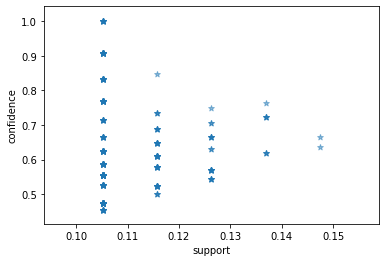

In [195]:
import matplotlib.pyplot as plt
%matplotlib inline
support = rules['support']
confidence = rules['confidence']
plt.scatter(support, confidence, alpha=0.5, marker="*")
plt.xlabel('support')
plt.ylabel('confidence') 
plt.show()

In [196]:
len(rules)
rules['antecedents'].head()

0    (0)
1    (1)
2    (0)
3    (6)
4    (0)
Name: antecedents, dtype: object

In [197]:
import networkx as nx
G = nx.DiGraph()
for i in range(len(data)):
    G.add_node(i)
for i in range(len(rules['antecedents'])):
    currentFrom = list(rules['antecedents'][i])
    currentTo = list(rules['consequents'][i])
    for j in range(len(currentFrom)):
        G.add_edge(currentFrom[j], currentTo[0])

## (7)畫出關聯圖

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


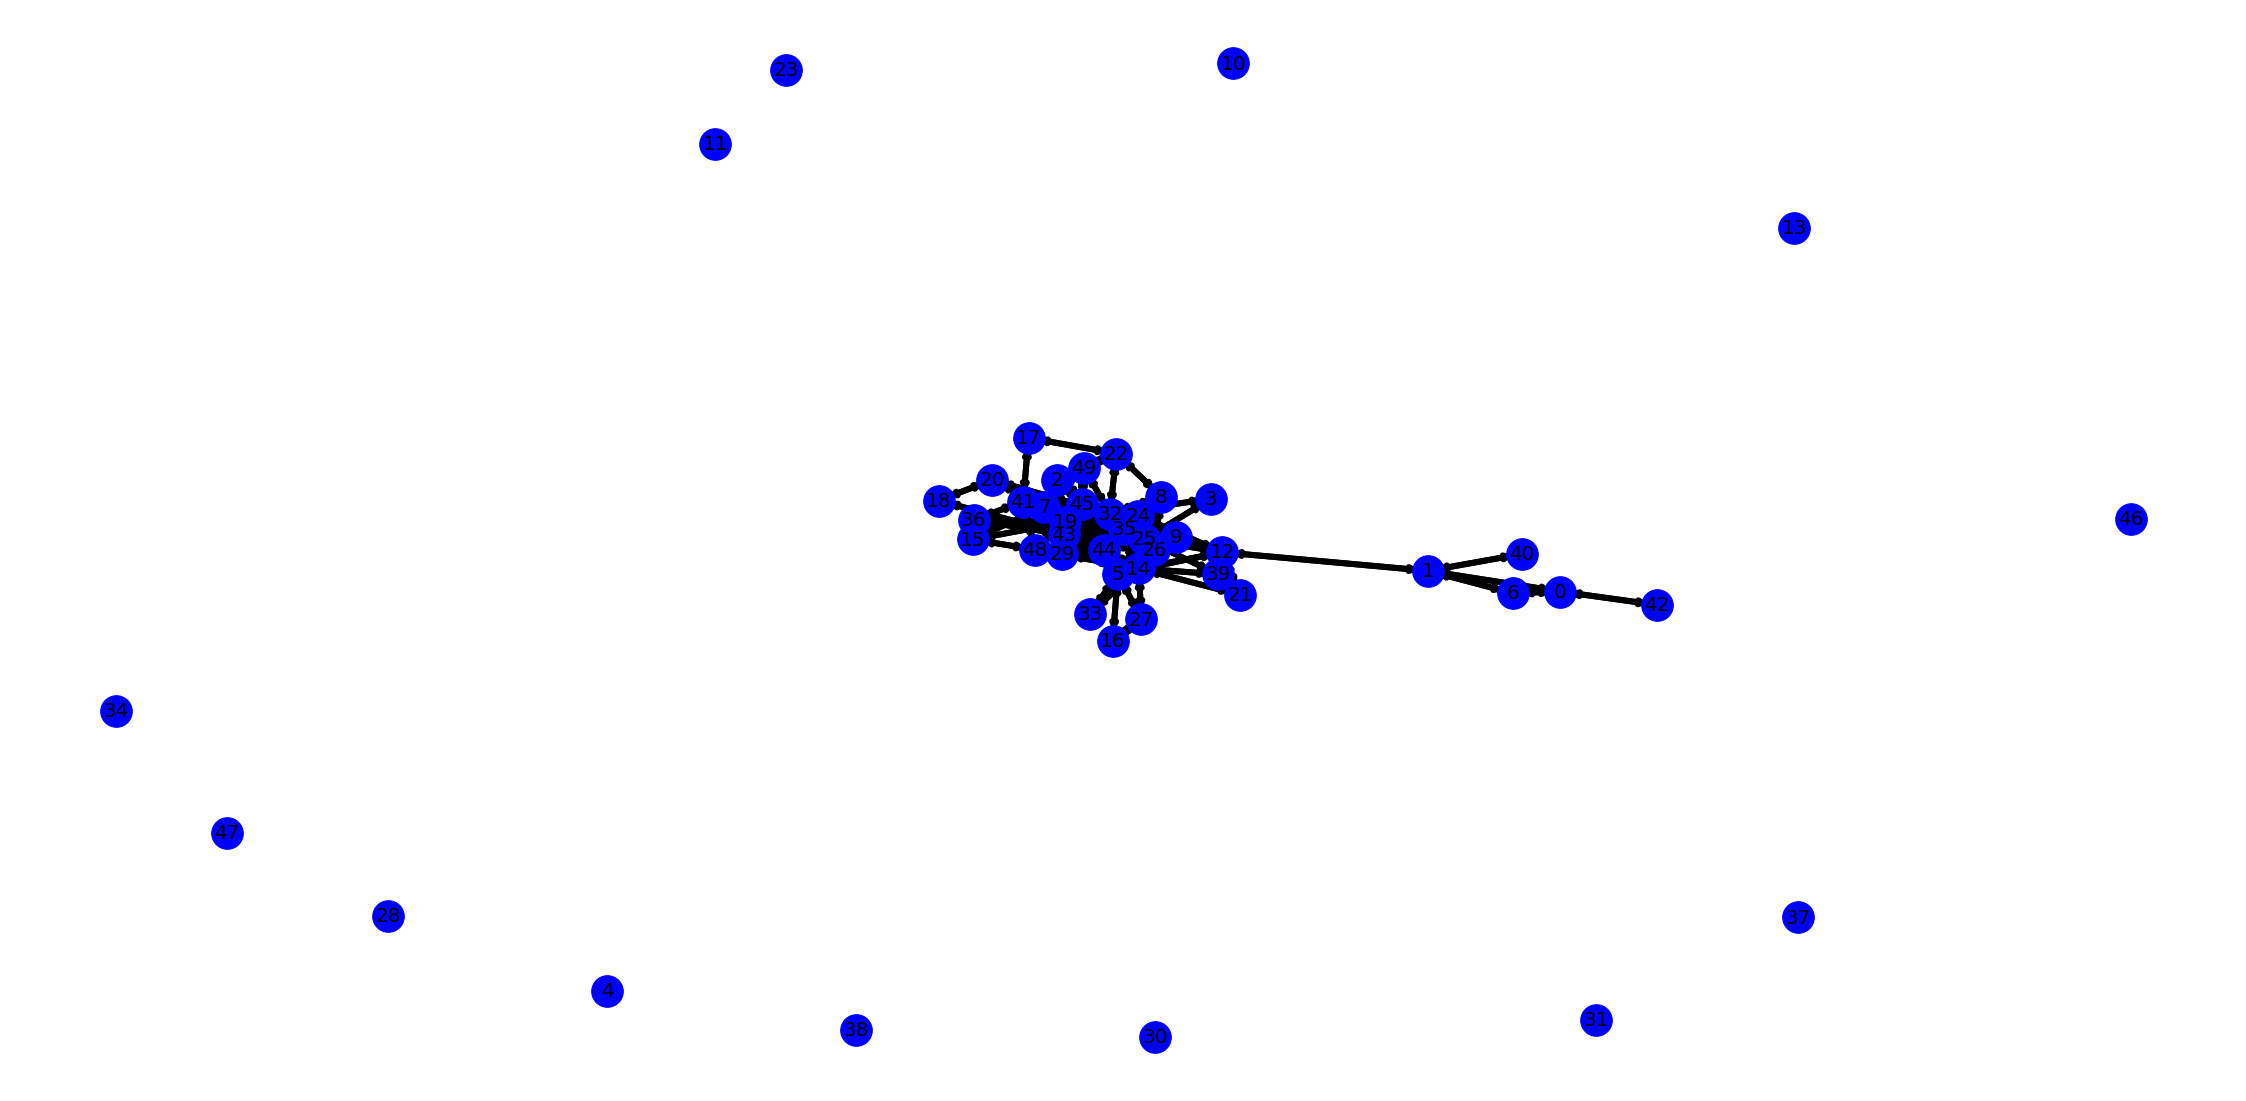

In [198]:
nodeList = list(range(50))

plt.figure(figsize=(40,20))

# positions for all nodes
pos = nx.fruchterman_reingold_layout(G)

# nodes
nx.draw_networkx_nodes(G, pos, nodelist=nodeList, node_color="b", node_size=1000)
nx.draw_networkx_edges(G, pos, width=6)

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.axis('off')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display

In [199]:
# 留言與其他板友不相似
list(nx.isolates(G))

[4, 10, 11, 13, 23, 28, 30, 31, 34, 37, 38, 46, 47]

In [200]:
# 小群體
from networkx.algorithms.approximation import dominating_set
dominating_set.min_edge_dominating_set(G)

{(0, 1),
 (2, 7),
 (3, 25),
 (5, 12),
 (8, 22),
 (9, 14),
 (15, 19),
 (16, 27),
 (17, 41),
 (18, 20),
 (24, 32),
 (26, 35),
 (29, 43),
 (45, 49)}

In [239]:
v,w,x,y,z,a,b = data['topic'][[0,1,6,40,46,11,23]]
v = literal_eval(v)
w = literal_eval(w)
x = literal_eval(x)
y = literal_eval(y)
z = literal_eval(z)
a = literal_eval(a)
b = literal_eval(b)

In [240]:
count_0 = Counter(v).most_common()
count_1 = Counter(w).most_common()
count_6 = Counter(x).most_common()
count_40 = Counter(y).most_common()
count_46 = Counter(z).most_common()
count_11 = Counter(a).most_common()
count_23 = Counter(b).most_common()

In [241]:
print(count_0[:10],'\n')
print(count_1[:10],'\n')
print(count_6[:10],'\n')
print(count_40[:10],'\n\n')
print(count_46[:10],'\n')
print(count_11[:10],'\n')
print(count_23[:10],'\n')

[('其他', 981), ('勇士', 233), ('湖人', 189), ('杜蘭特杜蘭特', 181), ('Smart', 171), ('火箭', 160), ('LBJ', 150), ('雷霆', 147), ('Marcus Smart', 142), ('林書豪', 134)] 

[('其他', 954), ('勇士', 109), ('雷霆', 93), ('湖人', 83), ('林書豪', 79), ('火箭', 67), ('快艇', 62), ('AD', 55), ('Anthony Davis', 47), ('詹皇', 37)] 

[('其他', 280), ('湖人', 72), ('快艇', 57), ('國王', 56), ('火箭', 51), ('金塊', 49), ('勇士', 47), ('雷霆', 43), ('杜蘭特杜蘭特', 39), ('林書豪', 38)] 

[('其他', 143), ('湖人', 95), ('快艇', 41), ('LBJ', 33), ('詹', 20), ('詹姆斯', 18), ('詹皇', 17), ('Howard', 15), ('林書豪', 15), ('James', 13)] 


[('Smart', 194), ('Marcus Smart', 150), ('其他', 90), ('勇士', 52), ('林書豪', 23), ('活塞', 15), ('Shaq', 13), ('林書豪人', 13), ('湖人', 5), ('Kobe', 5)] 

[('其他', 418), ('湖人', 53), ('Lillard', 49), ('Wade', 40), ('戰神', 33), ('魔獸湖人', 33), ('詹皇', 32), ('甜瓜', 29), ('熱火', 26), ('安東尼', 21)] 

[('其他', 323), ('Westbrook', 98), ('LBJ', 80), ('Curry', 58), ('湖人', 45), ('勇士', 30), ('Kobe', 28), ('騎士', 21), ('柯瑞', 17), (': LBJ', 16)] 

